In [43]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# Constants 
DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
OUT_PATH=DATA_PATH+'/results/fig_simu'

# GS 
GS_LIST = ['all_ngene500', 'highmean_ngene500', 'highvar_ngene500', 'highbvar_ngene500']
# GS_LIST = ['all_ngene500', 'highmean_ngene500', 'highbvar_ngene500']
# GS_LIST = ['highbvar_ngene500']
DIC_GS_NAME = {'all_ngene500': 'random genes', 
               'highmean_ngene500': 'random high-mean genes',
               'highvar_ngene500': 'random high-variance genes',
               'highbvar_ngene500': 'random overdispersed genes'}

# DATA_LIST
DATA_LIST = ['tms_facs.ncell_10k']

# Results 
DIC_RES_PATH = {'sctrs': DATA_PATH+'/simulation_data/score_file/@d.@g',
                'vam': DATA_PATH+'/simulation_data/score_file/result_vam/@d.@g.tsv',
                'vision': DATA_PATH+'/simulation_data/score_file/result_vision/@d.@g',
                'vision_norm': DATA_PATH+'/simulation_data/score_file/result_vision/@d.@g'
               }
METHOD_LIST = list(DIC_RES_PATH.keys())
DIC_METHOD_NAME = {'sctrs':'scTRS', 'vam':'VAM', 'vision':'Vision', 'vision_norm':'Vision-n'}
DIC_METHOD_COLOR = {'sctrs':'C0', 'vam':'C1', 'vision':'C2', 'vision_norm':'C3'}

for method in METHOD_LIST:
    if method not in DIC_METHOD_NAME.keys():
        DIC_METHOD_NAME[method] = method
    if method not in DIC_METHOD_COLOR.keys():
        DIC_METHOD_COLOR[method] = 'C%d'%len(DIC_METHOD_COLOR)

In [45]:
# Read results 
import itertools

q_list = 10**np.linspace(-3,0,25)
# q_list = [0.01, 0.05, 1]
dic_res = {}

for gs,dname,method in itertools.product(GS_LIST, DATA_LIST, METHOD_LIST):
# for gs,dname,method in [['highmean_ngene500', 'tms_facs.ncell_10k', 'vision']]:
    print(gs,dname,method)
    
    df_gs = pd.read_csv(DATA_PATH+'/simulation_data/gs_file/%s.gs'%gs, sep='\t', index_col=0)
    df_res = pd.DataFrame(index=df_gs.index, columns=q_list, data=-1)

    # load scTRS results 
    if 'sctrs' in method:
        for trait in df_gs.index:
            score_file = DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) + '/%s.score.gz'%trait
            if os.path.exists(score_file):
                temp_df = pd.read_csv(score_file, sep='\t')
                df_res.loc[trait, q_list] = np.quantile(temp_df['pval'], q_list)
            else:
                print('# file missing: ', score_file)
        dic_res['%s:%s:%s'%(dname,gs,method)] = df_res.copy()
            
    # load vam results 
    if method=='vam':
        score_file = DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) 
        if os.path.exists(score_file):
            temp_df = pd.read_csv(score_file, sep='\t')
            temp_df.columns = [x.replace('.','_') for x in temp_df.columns]
            drop_list = temp_df.columns[temp_df.mean(axis=0)>0.99]
            for trait in df_gs.index:
                if trait in drop_list: 
                    print('# %s dropped'%trait)
                    continue
                df_res.loc[trait, q_list] = np.quantile(temp_df[trait], q_list)
            df_res = df_res.loc[(df_res==-1).sum(axis=1)==0]
            dic_res['%s:%s:%s'%(dname,gs,method)] = df_res.copy()
        else:
            print('# file missing: ', score_file)
            
    # load vision and vision-norm result
    if method=='vision':
        for trait in df_gs.index:
            score_file = DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) + '/%s.score.gz'%trait
            if os.path.exists(score_file):
                temp_df = pd.read_csv(score_file, sep='\t')
                df_res.loc[trait, q_list] = np.quantile(temp_df['pval'], q_list)
            else:
                print('# file missing: ', score_file)
        dic_res['%s:%s:%s'%(dname,gs,method)] = df_res.copy()
        
    if method=='vision_norm':
        for trait in df_gs.index:
            score_file = DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) + '/%s.score.gz'%trait
            if os.path.exists(score_file):
                temp_df = pd.read_csv(score_file, sep='\t')
                df_res.loc[trait, q_list] = np.quantile(temp_df['norm_pval'], q_list)
            else:
                print('# file missing: ', score_file)
        dic_res['%s:%s:%s'%(dname,gs,method)] = df_res.copy()
    
            

all_ngene500 tms_facs.ncell_10k sctrs
all_ngene500 tms_facs.ncell_10k vam
all_ngene500 tms_facs.ncell_10k vision
all_ngene500 tms_facs.ncell_10k vision_norm
highmean_ngene500 tms_facs.ncell_10k sctrs
highmean_ngene500 tms_facs.ncell_10k vam
# highmean_ngene500_rep58 dropped
highmean_ngene500 tms_facs.ncell_10k vision
highmean_ngene500 tms_facs.ncell_10k vision_norm
highvar_ngene500 tms_facs.ncell_10k sctrs
highvar_ngene500 tms_facs.ncell_10k vam
highvar_ngene500 tms_facs.ncell_10k vision
highvar_ngene500 tms_facs.ncell_10k vision_norm
highbvar_ngene500 tms_facs.ncell_10k sctrs
highbvar_ngene500 tms_facs.ncell_10k vam
highbvar_ngene500 tms_facs.ncell_10k vision
highbvar_ngene500 tms_facs.ncell_10k vision_norm


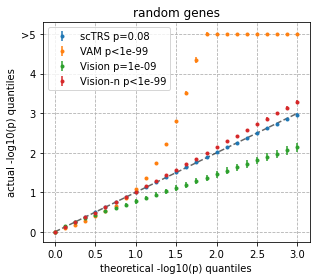

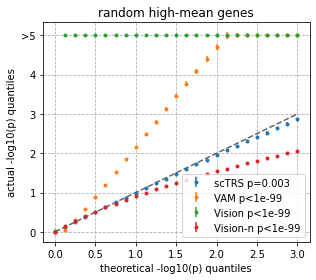

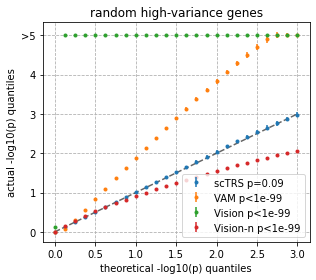

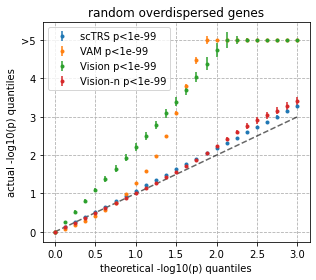

In [49]:
# Q-Q plot
dname = 'tms_facs.ncell_10k'
plot_list = ['%s:%s'%(dname, x) for x in GS_LIST]
# plot_list = ['tms_facs.ncell_10k:highmean_ngene500']
plot_method_list = METHOD_LIST

for plot_name in plot_list:
    dname,gs=plot_name.split(':')
    df_plot_mean = pd.DataFrame(index=q_list, columns=METHOD_LIST, data=-1)
    df_plot_se = pd.DataFrame(index=q_list, columns=METHOD_LIST, data=-1)
    
    for method in METHOD_LIST:
        res = '%s:%s'%(plot_name,method)
        df_plot_mean.loc[q_list, method] = dic_res[res][q_list].mean(axis=0)
        df_plot_se.loc[q_list, method] = dic_res[res][q_list].std(axis=0)/np.sqrt(dic_res[res].shape[0])
        
    df_plot_mean = df_plot_mean.clip(lower=1e-5)
    df_plot_se = df_plot_se.clip(lower=1e-10)
    
    # Add p-value
    temp_df = df_plot_mean.copy()
    temp_df = np.absolute(temp_df.T-df_plot_mean.index).T / df_plot_se
    df_plot_p = pd.DataFrame(index=df_plot_mean.index, columns=df_plot_mean.columns, 
                             data=(1-sp.stats.norm.cdf(temp_df))*2)
    df_plot_p.drop(1, axis=0, inplace=True)
    df_plot_p = df_plot_p.median(axis=0)
    dic_p = {x: 'p=%.1g'%df_plot_p.loc[x] if df_plot_p.loc[x]>1e-99 else 'p<1e-99' for x in METHOD_LIST}        
            
    plt.figure(figsize=[4.5,4])
    df_plot_logerr = np.log10(df_plot_mean+1.96*df_plot_se) - np.log10(df_plot_mean)
    for method in METHOD_LIST:
        plt.errorbar(-np.log10(df_plot_mean.index), -np.log10(df_plot_mean[method]), 
                     yerr = df_plot_logerr[method], 
                     label='%s %s'%(DIC_METHOD_NAME[method], dic_p[method]),
                     fmt='.', markersize=6, color=DIC_METHOD_COLOR[method])

    plt.plot([0, 3], [0, 3], linestyle='--', color='k', alpha=0.6)
    plt.xlabel('theoretical -log10(p) quantiles')
    plt.ylabel('actual -log10(p) quantiles')
    plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,'>5'])
    plt.grid(linestyle='--')
    plt.title(DIC_GS_NAME[gs])
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_PATH+'/%s.%s.pdf'%(dname,gs))
    plt.show()
    
#     break

In [31]:
dname

'tms_facs.ncell_10k'